In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset

In [2]:
from imblearn.under_sampling import RandomUnderSampler

# Data Processing

## set time and regional domain

In [3]:
isl        = 1
YYYY_list  = [2012,2013];
nYYYY      = len(YYYY_list)

## read data

In [4]:
datadir         = '/home/disk/eos12/wycheng/data/US'

island_file     = f'{datadir}/island/island_1deg_US.nc'
island_data     = xr.open_dataset(island_file)

for iyear in range(nYYYY):
    YYYY        = str(YYYY_list[iyear])
    F_file      = f'{datadir}/WWLLN/WWLLN_{YYYY}_F_cg_1deg3hr_US.nc'
    cape_file   = f'{datadir}/ERA5/ERA5_{YYYY}_cape_cg_1deg3hr_US.nc'
    pcp_file    = f'{datadir}/TRMM/TRMM_{YYYY}_pcp_cg_1deg3hr_US.nc'

    if (iyear==0):
        F_data      = xr.open_dataset(F_file)
        cape_data   = xr.open_dataset(cape_file)
        pcp_data    = xr.open_dataset(pcp_file)

    else:
        F_data_tmp      = xr.open_dataset(F_file)
        cape_data_tmp   = xr.open_dataset(cape_file)
        pcp_data_tmp    = xr.open_dataset(pcp_file)

        F_data_old      = F_data.copy()
        cape_data_old   = cape_data.copy()
        pcp_data_old    = pcp_data.copy()

        del(F_data)
        del(cape_data)
        del(pcp_data)

        F_data          = xr.concat([F_data_old['F'],F_data_tmp['F']],dim='Time').to_dataset()
        cape_data       = xr.concat([cape_data_old['cape'],cape_data_tmp['cape']],dim='Time').to_dataset()
        pcp_data        = xr.concat([pcp_data_old['pcp'],pcp_data_tmp['pcp']],dim='time').to_dataset()


In [5]:
data_array = xr.combine_by_coords([island_data,\
                                   F_data,\
                                   cape_data,\
                                   pcp_data.rename({'time': 'Time'}).assign_coords({"Time": F_data.Time})], combine_attrs="drop")

In [6]:
data_array

<xarray.Dataset>
Dimensions:  (Time: 5848, lat: 40, lon: 75)
Coordinates:
  * Time     (Time) datetime64[ns] 2012-01-01 ... 2013-12-31T21:00:00
  * lat      (lat) float32 20.5 21.5 22.5 23.5 24.5 ... 55.5 56.5 57.5 58.5 59.5
  * lon      (lon) float32 -134.5 -133.5 -132.5 -131.5 ... -62.5 -61.5 -60.5
Data variables:
    F        (Time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cape     (Time, lat, lon) float32 0.0 0.03581 0.8051 ... 1.234 2.269 6.01
    island   (lat, lon) int32 ...
    pcp      (Time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan

In [7]:
dataset = data_array.where( (data_array.island == 1) & (data_array.pcp<0.833) ).to_dataframe().dropna(axis=0)

In [8]:
dataset = dataset.assign(isT=np.where( (dataset.F>=1),1,0))
dataset = dataset.assign(isDT=np.where( (dataset.pcp<0.833) & (dataset.F>=1),1,0))

In [9]:
dataset

F        cape  island       pcp  isT  \
Time                lat  lon                                                
2012-01-01 00:00:00 20.5 -105.5    0.0   26.936972     1.0  0.045319    0   
                         -104.5    0.0  193.959839     1.0  0.619060    0   
                         -102.5    4.0    0.000000     1.0  0.698779    1   
                         -101.5  511.0   17.618164     1.0  0.047142    1   
                         -100.5  806.0   28.618326     1.0  0.000000    1   
...                                ...         ...     ...       ...  ...   
2013-12-31 21:00:00 49.5 -71.5     0.0    0.001953     1.0  0.000000    0   
                         -70.5     0.0    0.001953     1.0  0.000000    0   
                         -69.5     0.0    0.030273     1.0  0.000000    0   
                         -68.5     0.0    0.497640     1.0  0.000000    0   
                         -67.5     0.0    3.034139     1.0  0.000000    0   

                                 isDT  
Time                lat  lon           
2012-01-01 00:00:00 20.5 -105.5     0  
                         -104.5     0  
                         -102.5     1  
                         -101.5     1  
                         -100.5     1  
...                               ...  
2013-12-31 21:00:00 49.5 -71.5      0  
                         -70.5      0  
                         -69.5      0  
                         -68.5      0  
                         -67.5      0  

[6366461 rows x 6 columns]

## check data

In [10]:
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6366461 entries, (Timestamp('2012-01-01 00:00:00'), 20.5, -105.5) to (Timestamp('2013-12-31 21:00:00'), 49.5, -67.5)
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   F       float32
 1   cape    float32
 2   island  float64
 3   pcp     float32
 4   isT     int64  
 5   isDT    int64  
dtypes: float32(3), float64(1), int64(2)
memory usage: 243.0 MB


## formatting input (training/test) data

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
feature_name  = ['cape','pcp']
output_name   = ['isDT']

X = dataset[feature_name]
y = dataset[output_name]

In [13]:
print(y.where(y.isDT==0).count())
print(y.where(y.isDT>=1).count())

isDT    6002568
dtype: int64
isDT    363893
dtype: int64


In [14]:
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=0.33, random_state=None)
X_train, y_train = undersample.fit_resample(X_train_raw, y_train_raw)

In [15]:
print(X_train.info())
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731388 entries, 0 to 731387
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cape    731388 non-null  float32
 1   pcp     731388 non-null  float32
dtypes: float32(2)
memory usage: 5.6 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731388 entries, 0 to 731387
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   isDT    731388 non-null  int64
dtypes: int64(1)
memory usage: 5.6 MB
None


# ML

## R14

In [16]:
import scipy as sp
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.preprocessing import normalize

In [17]:
class R14:
    
    def fit(CAPE,pcp,y):

        thrs = sp.optimize.fminbound(lambda x: -f1_score(y, ((CAPE*pcp > x) * 1.0).astype(int)), 0, 4000)
        fval = f1_score(y, ((CAPE*pcp >= thrs) * 1.0).astype(int))
        
        return thrs, fval
    
    def predict(CAPE,pcp,thrs):
        
        y_predict = ((CAPE*pcp >= thrs) * 1.0).astype(int)
        y_predict_proba = CAPE*pcp
        
        return y_predict, y_predict_proba/np.max(y_predict_proba)

In [18]:
[r14_thrs,fval] = R14.fit(X_train['cape'],X_train['pcp'],y_train)

In [19]:
print(r14_thrs, fval)

0.02382823753651632 0.6099457755484401


In [20]:
r14_thrs_linspace = np.linspace(np.max(r14_thrs-10,0),r14_thrs+10,num=20)
fval_linspace     = np.zeros(np.shape(r14_thrs_linspace))

In [21]:
i = 0
for r14_thrs_i in r14_thrs_linspace:
    fval_linspace[i] = f1_score(y_train['isDT'], ((X_train['cape']*X_train['pcp'] >= r14_thrs_i) * 1.0).astype(int))
    i = i+1

Text(0, 0.5, 'F1 score')

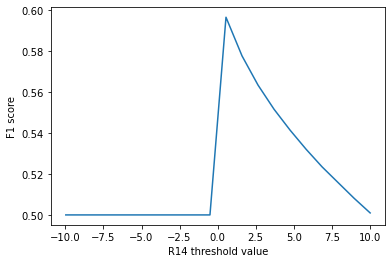

In [22]:
plt.plot(r14_thrs_linspace,fval_linspace)
plt.xlabel('R14 threshold value')
plt.ylabel('F1 score')

In [23]:
y_predict_r14, y_predict_prob_r14 = R14.predict(X_test['cape'],X_test['pcp'],r14_thrs)

## random forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
rfclf = RandomForestClassifier(n_estimators=10, max_depth=4, min_samples_split=10, random_state=0)

In [26]:
rfclf.fit(X_train[feature_name], y_train[output_name])

<ipython-input-26-f484fe52f948>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf.fit(X_train[feature_name], y_train[output_name])


RandomForestClassifier(max_depth=4, min_samples_split=10, n_estimators=10,
                       random_state=0)

In [27]:
y_predict_rfclf = rfclf.predict(X_test[feature_name])

## Model Evaluation

In [28]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import plot_roc_curve

In [29]:
pd.DataFrame(
    [[precision_score(y_test['isDT'], y_predict_r14),\
      recall_score(y_test['isDT'], y_predict_r14),\
      f1_score(y_test['isDT'], y_predict_r14)],\
     [precision_score(y_test['isDT'], y_predict_rfclf),\
      recall_score(y_test['isDT'], y_predict_rfclf),\
      f1_score(y_test['isDT'], y_predict_rfclf)]],
    columns=['Precision Score', 'Recall Score', 'F1 Score'],
    index=['R14', 'RFC']
).style.apply(lambda x: ["background: yellow" if v == x.max() else "" for v in x], axis = 0)

,Precision Score,Recall Score,F1 Score
R14,0.290995,0.507032,0.369771
RFC,0.301098,0.601314,0.401268


In [30]:
auc_rfclf = metrics.roc_auc_score(y_test, rfclf.predict_proba(X_test)[:,1])
auc_r14   = metrics.roc_auc_score(y_test, y_predict_prob_r14)
print(auc_rfclf, auc_r14)

0.8820958965628892 0.7255866987552245


In [31]:
xthrs = np.linspace(0,4000,20)
fpr = []
tpr = []
for i in range(np.size(xthrs)):
    yp, fv = R14.predict(X_test['cape'],X_test['pcp'],xthrs[i])
    tn, fp, fn, tp = confusion_matrix(y_test['isDT'], yp).ravel()
    fpr.append( (fp/(fp+tn)) ) 
    tpr.append( (tp/(tp+fn)) )

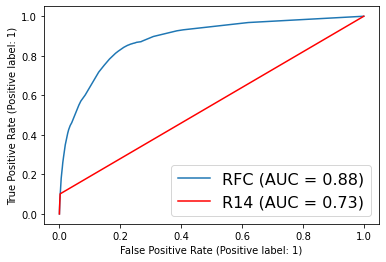

In [32]:
plot_roc_curve(rfclf, X_test, y_test, label='RFC (AUC = %0.2f)'%(auc_rfclf) ) 
plt.plot(fpr, tpr, 'r-',label='R14 (AUC = %0.2f)'%(auc_r14))
plt.legend(fontsize=16)
plt.show()  

In [33]:
pd.DataFrame(
    confusion_matrix(y_test['isDT'], y_predict_rfclf),
    columns=['Predicted No DT', 'Predicted DT'],
    index=['True No DT', 'True DT']
)

,Predicted No DT,Predicted DT
True No DT,1813210,167626
True DT,47881,72216


In [34]:
pd.DataFrame(
    confusion_matrix(y_test['isDT'], y_predict_r14),
    columns=['Predicted No DT', 'Predicted DT'],
    index=['True No DT', 'True DT']
)

,Predicted No DT,Predicted DT
True No DT,1832471,148365
True DT,59204,60893


## Plots

In [35]:
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

In [36]:
idx = y_test.index
y_predict_r14_df   = pd.DataFrame(y_predict_r14, index=idx, columns=['y_predict_r14'])
y_predict_rfclf_df = pd.DataFrame(y_predict_rfclf, index=idx, columns=['y_predict_rfclf'])

In [37]:
def plot_map(figsize,data,cmap,vmin=None,vmax=None,title=None,unit=None):
    
    fig   = plt.figure(figsize=figsize)

    pcm = data.plot.pcolormesh("lon","lat",
        subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="white"),
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=vmin,vmax=vmax,
        add_colorbar = False,
    )
    pcm.axes.set_extent([-135, -60, 20, 60], ccrs.PlateCarree())
    gl = pcm.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-130, -120, -110, -100, -90, -80, -70, -60])
    gl.ylocator = mticker.FixedLocator([20, 30, 40, 50, 60])
    gl.xlabels_top   = False
    gl.ylabels_right = False
    pcm.axes.coastlines()
    plt.title(title)

    divider = make_axes_locatable(pcm.axes)
    cax     = divider.append_axes("right", size="2%", pad=1, axes_class=plt.Axes)
    cbar    = plt.colorbar(pcm, cax=cax,extend='max')
    plt.text(vmin,vmax*1.08,unit)

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


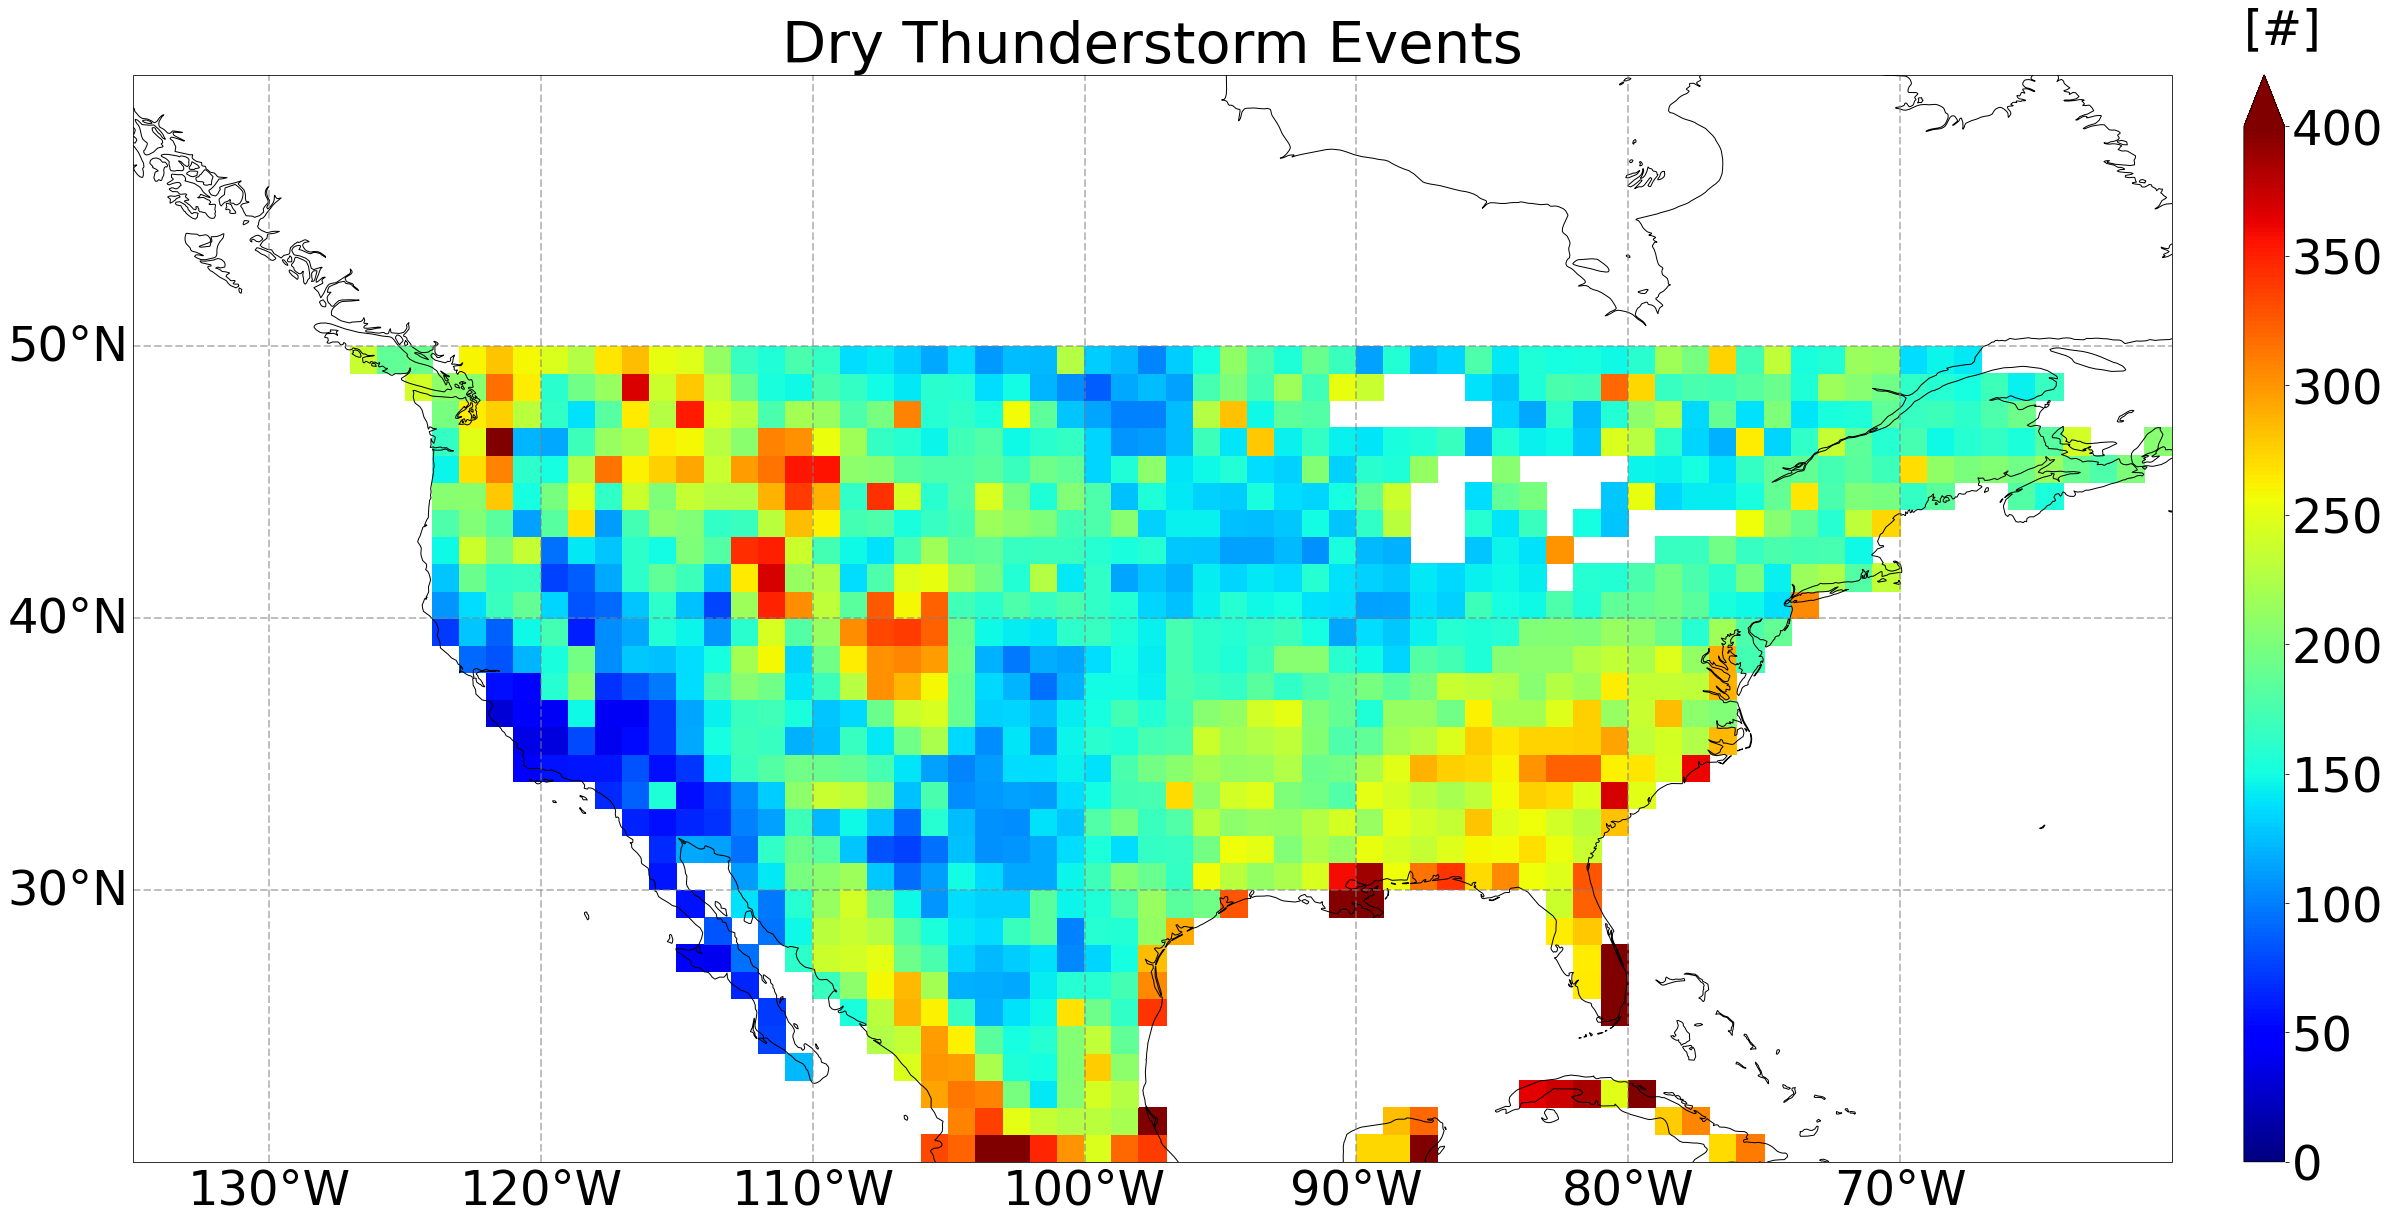

In [38]:
plt.rcParams.update({'font.size': 48})
figsize = (40,20)
data  = y_predict_r14_df['y_predict_r14'].groupby(['lat','lon']).sum().to_xarray().where(island_data.island==1)
cmap  = plt.get_cmap('jet')
vmin  = 0
vmax  = 400
title = 'Dry Thunderstorm Events'
unit  = '[#]'

plot_map(figsize,data=data,cmap=cmap,vmin=vmin,vmax=vmax,title=title,unit=unit)

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


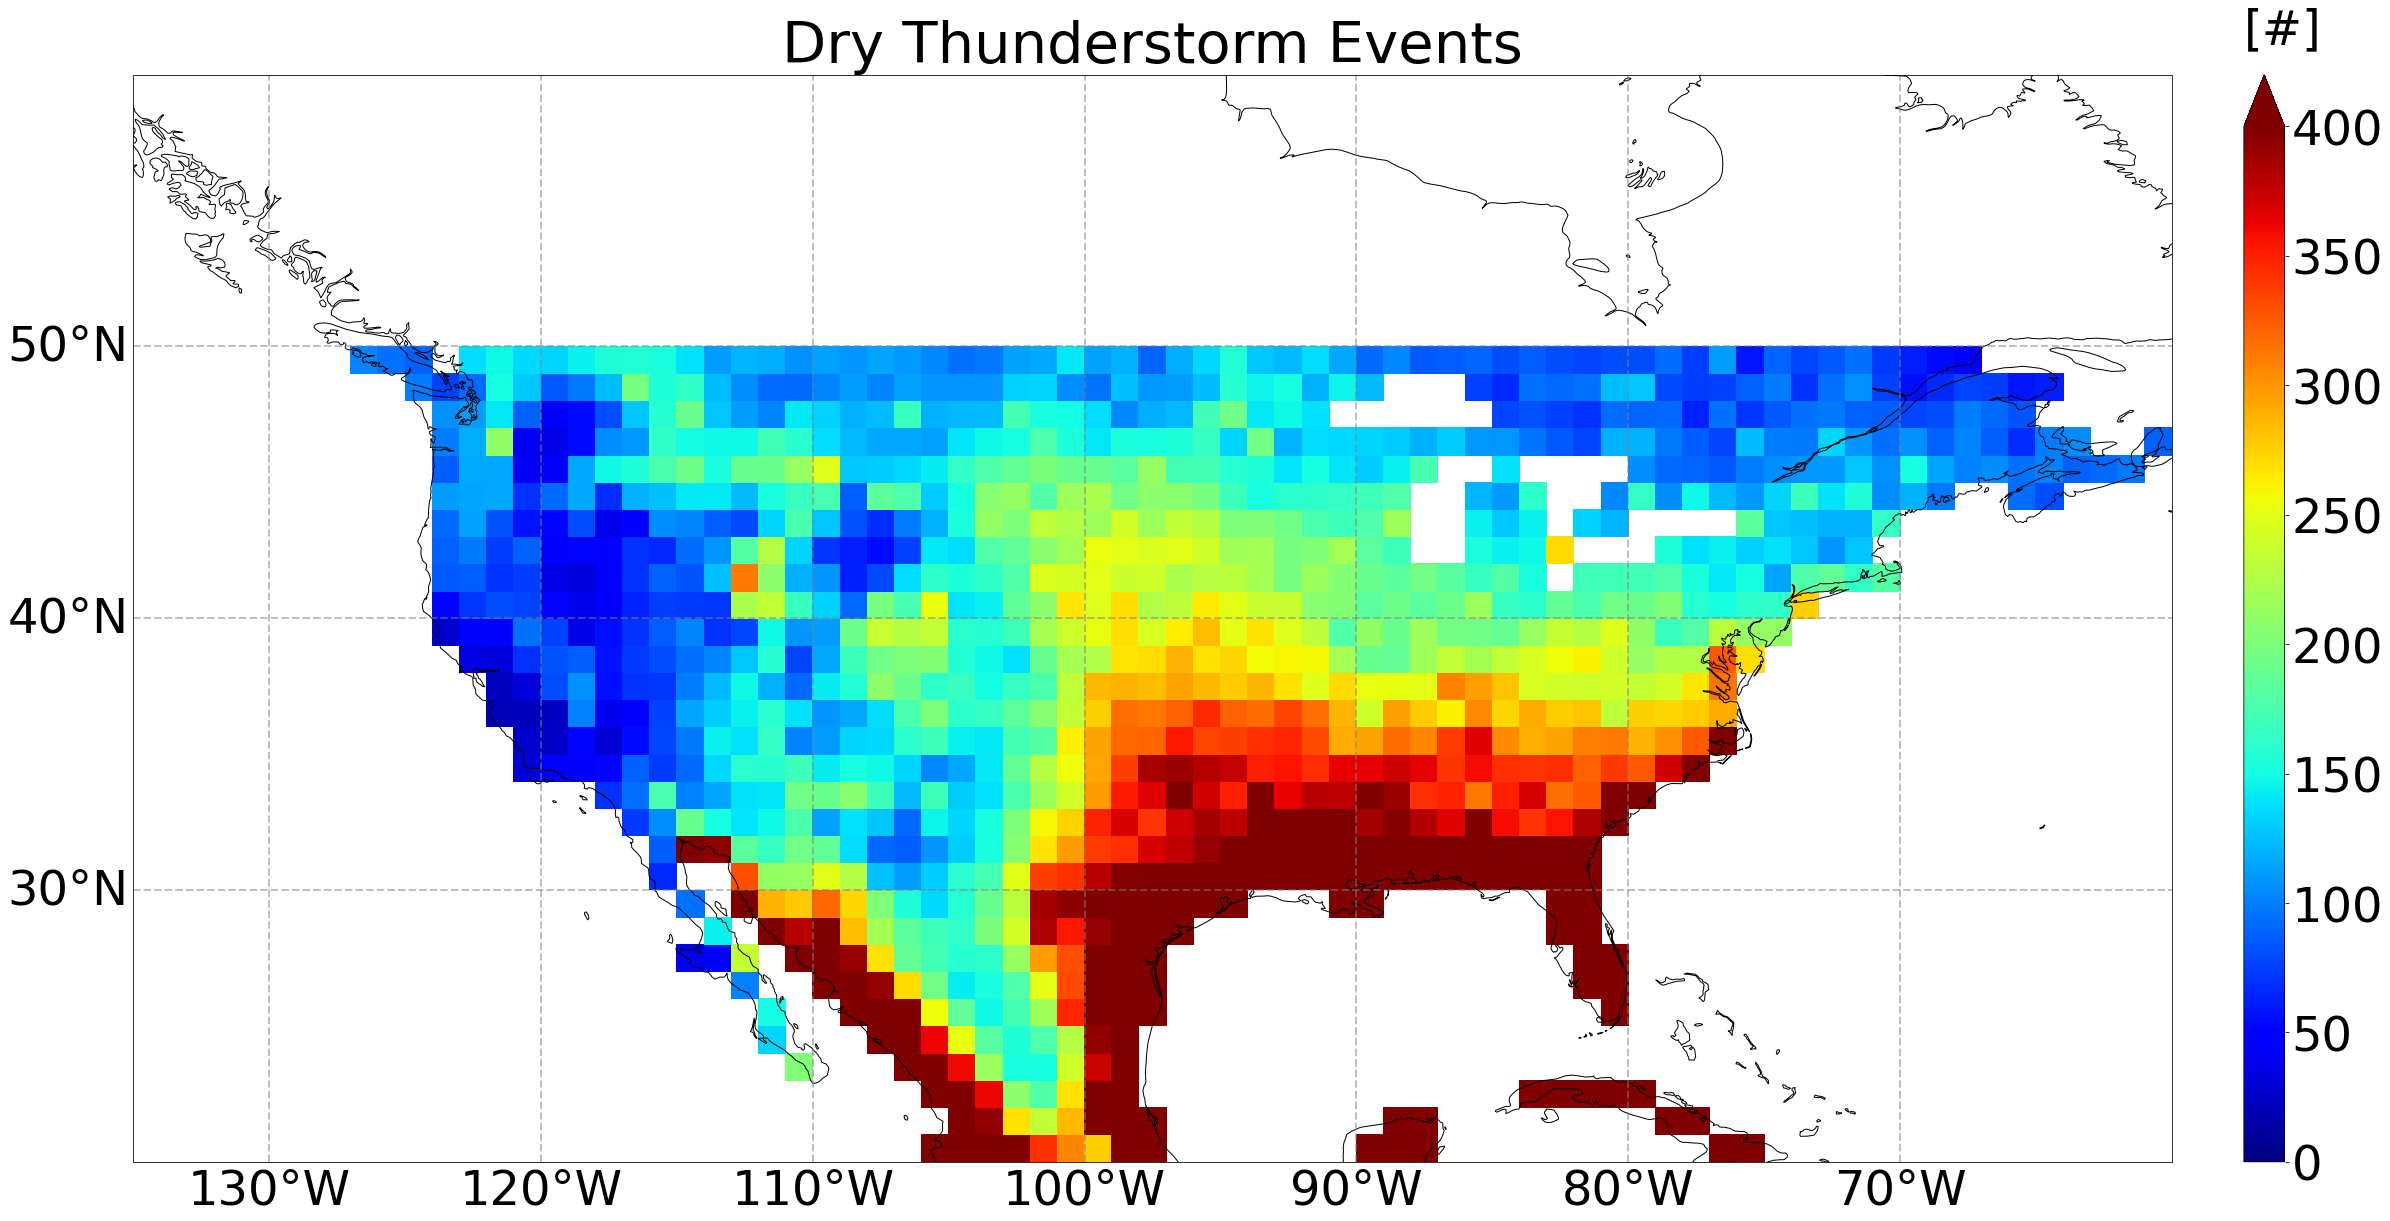

In [39]:
plt.rcParams.update({'font.size': 48})
figsize = (40,20)
data  = y_predict_rfclf_df['y_predict_rfclf'].groupby(['lat','lon']).sum().to_xarray().where(island_data.island==1)
cmap  = plt.get_cmap('jet')
vmin  = 0
vmax  = 400
title = 'Dry Thunderstorm Events'
unit  = '[#]'

plot_map(figsize,data=data,cmap=cmap,vmin=vmin,vmax=vmax,title=title,unit=unit)

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


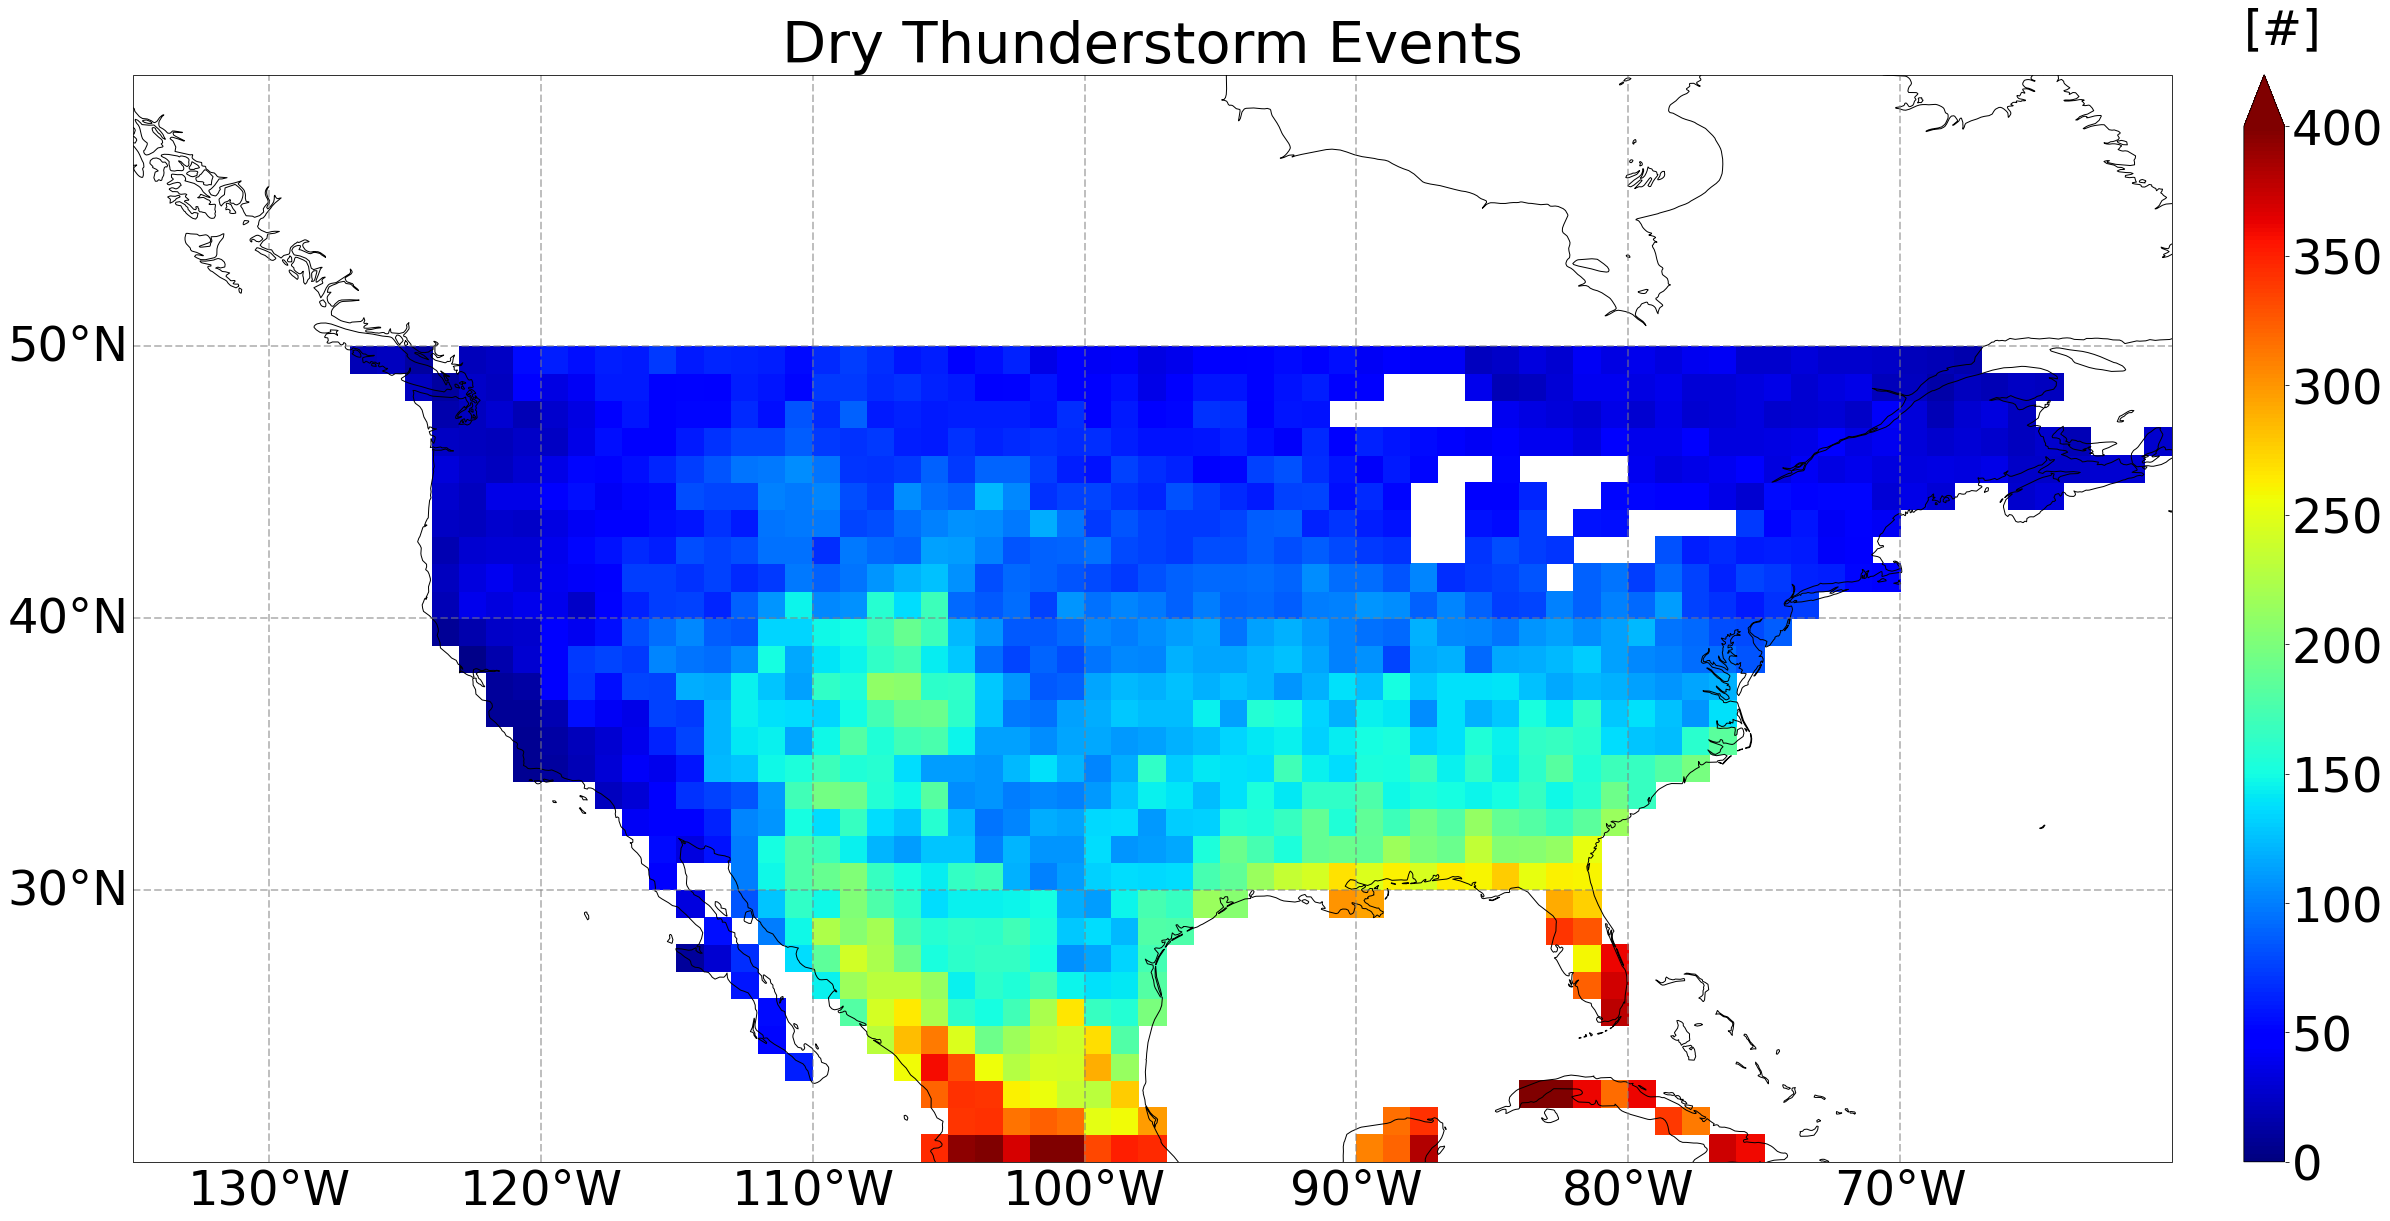

In [40]:
plt.rcParams.update({'font.size': 48})
figsize = (40,20)
data  = y_test['isDT'].groupby(['lat','lon']).sum().to_xarray().where(island_data.island==1)
cmap  = plt.get_cmap('jet')
vmin  = 0
vmax  = 400
title = 'Dry Thunderstorm Events'
unit  = '[#]'

plot_map(figsize,data=data,cmap=cmap,vmin=vmin,vmax=vmax,title=title,unit=unit)